In [10]:
import json
import requests
import numpy as np
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn import svm

import matplotlib.pyplot as plt

In [14]:
# !rm *.json
jail = requests.get("https://connect.biorxiv.org/relate/collection_json.php?grp=181").json()
json.dump(jail, open("jail.json", "w"))

In [17]:
jail = json.load(open("jail.json", "r"))

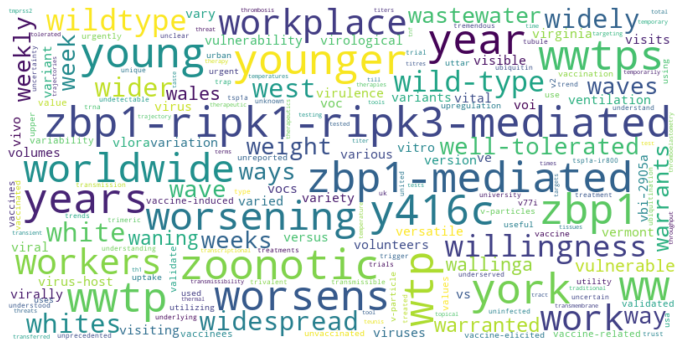

In [20]:
max_features = 2000
v_abs = TfidfVectorizer(
    input="content", 
    encoding="utf-8",
    decode_error="replace",
    strip_accents="unicode",
    lowercase=True,
    analyzer="word",
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9_-]+\b",
    ngram_range=(1, 1),
    max_features=max_features,
    norm="l2",
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    max_df=1.0,
    min_df=1
)

corpus_abs = [a["rel_abs"] for a in jail["rels"]]
v_abs.fit(corpus_abs)

wordcloud = WordCloud(
    width=800,
    height=400,
    max_font_size=50,
    max_words=200,
    background_color="white").fit_words(v_abs.vocabulary_)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

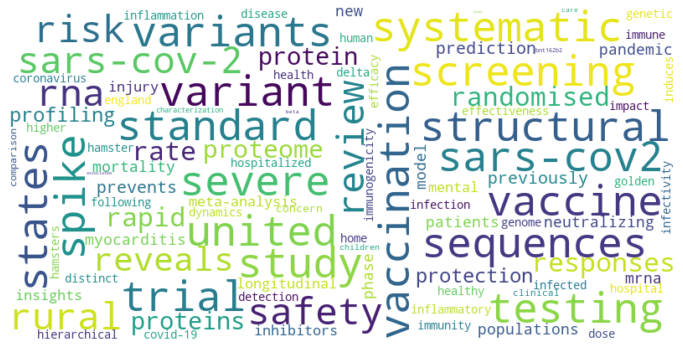

In [22]:
max_features = 100
v_title = TfidfVectorizer(
    input="content", 
    encoding="utf-8",
    decode_error="replace",
    strip_accents="unicode",
    lowercase=True,
    analyzer="word",
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9_-]+\b",
    ngram_range=(1, 1),
    max_features=max_features,
    norm="l2",
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    max_df=1.0,
    min_df=1
)

corpus_title = [a["rel_title"] for a in jail["rels"]]
v_title.fit(corpus_title)

wordcloud = WordCloud(
    width=800,
    height=400,
    max_font_size=50,
    max_words=200,
    background_color="white").fit_words(v_title.vocabulary_)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Search Egine

In [25]:
vocab = v_abs.vocabulary_
idf = v_abs.idf_
english_stop_words = _stop_words.ENGLISH_STOP_WORDS
punc = "'!\"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'" # removed hyphen from string.punctucation
trans_table = {ord(c): None for c in punc}

# print(len(idf))
# print([i for i in zip(vocab, idf)])

In [27]:
def makedict(s, forceidf=None, scale=1.0):
    words = set(s.lower().translate(trans_table).strip().split())
    words = set(w for w in words if len(w) > 1 and (not w in english_stop_words))
    idfd = {}
    for w in words:  # todo: if we're using bigrams in vocab then this won't search over them
        if forceidf is None:
            if w in vocab:
                idfval = idf[vocab[w]] * scale  # we have idf for this
            else:
                idfval = 1.0 * scale  # assume idf 1.0(low)
        else:
            idfval = forceidf
        idfd[w] = idfval
        
    return idfd

In [28]:
def merge_dicts(dlist):
    m = {}
    for d in dlist:
        for k,v in d.items():
            m[k] = m.get(k, 0) + v
    
    return m

In [41]:
search_dict = []
for p in jail["rels"]:

    dict_title = makedict(p["rel_title"], forceidf=10, scale=3)
    authors_str = "".join([author["author_name"] for author in p["rel_authors"]])
    dict_authors = makedict(authors_str, forceidf=5)
    dict_summary = makedict(p["rel_abs"])
    qdict = merge_dicts([dict_title, dict_authors, dict_summary])
    
    search_dict.append(qdict)

In [42]:
print("writing search.json")
json.dump(search_dict, open("search.json", "w"))

writing search.json


In [49]:
def search(q):
    qparts = q.lower().strip().split()
    # accumulate scores
    n = len(jail["rels"])
    scores = []
    for i, sd in enumerate(search_dict):
        score = sum(sd.get(q, 0) for q in qparts)
        if score == 0:
            continue  # no match whatsoever, dont include
        score += 1.0 * (n - i) / n  # give a small boost to more recent papers(low index)
        scores.append((score, jail["rels"][i]))
    scores.sort(reverse=True, key=lambda x: x[0])  # descending
    papers = [x[1] for x in scores if x[0] > 0]
    if len(papers) > 40:
        papers = papers[:40]
        
    return papers
        

In [52]:
search("USA")

[{'rel_title': 'Comparative transmissibility of SARS-CoV-2 variants Delta and Alpha in New England, USA',
  'rel_doi': '10.1101/2021.10.06.21264641',
  'rel_link': 'http://medrxiv.org/cgi/content/short/2021.10.06.21264641',
  'rel_abs': 'The severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) Delta variant quickly rose to dominance in mid-2021, displacing other variants, including Alpha. Studies using data from the United Kingdom and India estimated that Delta was 40-80% more transmissible than Alpha, allowing Delta to become the globally dominant variant. However, it was unclear if the ostensible difference in relative transmissibility was due mostly to innate properties of Deltas infectiousness or differences in the study populations. To investigate, we formed a partnership with SARS-CoV-2 genomic surveillance programs from all six New England US states. By comparing logistic growth rates, we found that Delta emerged 37-163% faster than Alpha in early 2021 (37% Massachusetts

## Show Similar Papers

In [54]:
X = v_abs.transform(corpus_abs)
D = np.dot(X, X.T).todense()
svm_sim = {}
ntake = 40

for i in range(ntake):
    y = np.zeros(X.shape[0])
    y[i] = 1
    clf = svm.LinearSVC(class_weight="balanced", verbose=False, max_iter=10000, tol=1e-4, C=1.0)
    clf.fit(X, y)
    s = clf.decision_function(X)
    IX = np.argsort(-s)
    ixc = [int(IX[j]) for j in range(ntake)]
    ds = [int(D[i, IX[j]]*1000) for j in range(ntake)]
    svm_sim[i] = list(zip(ixc, ds))
    
json.dump(svm_sim, open("svm_sim.json", "w"))
    

In [55]:
with open("svm_sim.json", "r") as f:
    sim_dict = json.load(f)

doi_to_ix = {}

for i, j in enumerate(jail['rels']):
    doi_to_ix[j["rel_doi"]] = i
    
def show_similar_papers(doi_prefix=None, doi_suffix=None):
    doi = f"{doi_prefix}/{doi_suffix}"  # reconstruct the full doi
    pix = doi_to_ix.get(doi)
    if pix is None:
        papers = []
    else:
        sim_ix, match = zip(*sim_dict[str(pix)][:40])  # indices of closest papers
        print(sim_ix)
        papers = [jail["rels"][cix] for cix in sim_ix]

    return papers

In [56]:
show_similar_papers("10.1101", "2020.03.18.20038455")

[]